In [142]:
import cv2
from skimage.transform import resize
from os import listdir, walk
from os.path import isfile, join
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
import pickle
import itertools
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam



In [109]:
test0 = pd.read_csv('data/Data/fungiclef2022/FungiCLEF2022_test_metadata.csv',sep = ',')

In [114]:
test0.head(3)

,Unnamed: 0,ObservationId,eventDate,month,day,countryCode,Location_lvl0,Location_lvl3,Location_lvl2,Location_lvl1,Substrate,Habitat,filename
0,0,3305985310,2021-06-15T00:00:00,6.0,15.0,DK,Ellesøen,Denmark,Sjælland,Køge,dead wood (including bark),Bog woodland,0-3305985310.JPG
1,1,3305985310,2021-06-15T00:00:00,6.0,15.0,DK,Ellesøen,Denmark,Sjælland,Køge,dead wood (including bark),Bog woodland,1-3305985310.JPG
2,2,3305985310,2021-06-15T00:00:00,6.0,15.0,DK,Ellesøen,Denmark,Sjælland,Køge,dead wood (including bark),Bog woodland,2-3305985310.JPG


In [23]:
test1 = pd.read_csv('data/Data/fungiclef2022/DF20-train_metadata.csv',sep = ',')

In [32]:
test1.head(3)
test1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266344 entries, 0 to 266343
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gbifID                266344 non-null  int64  
 1   eventDate             266328 non-null  object 
 2   year                  266328 non-null  float64
 3   month                 266328 non-null  float64
 4   day                   266328 non-null  float64
 5   countryCode           266344 non-null  object 
 6   locality              266273 non-null  object 
 7   taxonID               266344 non-null  float64
 8   scientificName        266344 non-null  object 
 9   kingdom               266344 non-null  object 
 10  phylum                266344 non-null  object 
 11  class                 266315 non-null  object 
 12  order                 266187 non-null  object 
 13  family                263975 non-null  object 
 14  genus                 266344 non-null  object 
 15  

In [28]:
mash = list(test1.scientificName.unique())

In [41]:
test2 = pd.read_csv('data/Data/fungiclef2022/DF20-val_metadata.csv',sep = ',')
len(mash)

1604

In [36]:
test2.head(2)
test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29594 entries, 0 to 29593
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gbifID                29594 non-null  int64  
 1   eventDate             29593 non-null  object 
 2   year                  29593 non-null  float64
 3   month                 29593 non-null  float64
 4   day                   29593 non-null  float64
 5   countryCode           29594 non-null  object 
 6   locality              29584 non-null  object 
 7   taxonID               29594 non-null  float64
 8   scientificName        29594 non-null  object 
 9   kingdom               29594 non-null  object 
 10  phylum                29594 non-null  object 
 11  class                 29591 non-null  object 
 12  order                 29577 non-null  object 
 13  family                29330 non-null  object 
 14  genus                 29594 non-null  object 
 15  specificEpithet    

In [40]:
mash = list(test2.scientificName.unique())
len(mash)

1604

- From Big Data mushrooms we have two lists, splitted in test and validation.
- - 1604 kinds of fungis
- - 266344 / 19594 , test/ val


- Smalll data set
- - Categories : 'Agaricus' : 0,'Amanita' : 1,'Boletus' : 2,'Cortinarius' : 3,'Entoloma' : 4,'Hygrocybe' : 5,
    'Lactarius' : 6,'Russula' : 7,'Suillus' : 8
- - number of pics per category: [352, 749, 1072, 835, 363, 315, 1562, 1147, 310]

# Day-1
- Work on the small data set.
- - make batches of downsize files
- - see issue with the premature end of JPEG
- - - make model run with 300 img per category
- - - make model work for 1000 pics per category using augmentation.Keras

In [189]:
def getList(dict):
    """
    This function returns the list of keys in a dictionary
    """
    return dict.keys()


CLASSES = {'Agaricus' : 0,'Amanita' : 1,'Boletus' : 2,'Cortinarius' : 3,'Entoloma' : 4,'Hygrocybe' : 5,
    'Lactarius' : 6,'Russula' : 7,'Suillus' : 8
                }

def get_label(key ,class_mush = CLASSES):
    """
    You can get the labeled name of the mushroom by giving 
    the index or the index by giving the key
    """
    if type(key) == str:
        return class_mush[key]
    elif type(key) == int:
        return list(CLASSES.keys())[list(CLASSES.values()).index(key)]


def upload_dir_labels(directory,mapping =CLASSES, k = 300):
    """
    give the list of photos from directory and the labels.
    k = number of pictures I want to take from each FOLDER. 
    """
    label = []
    dir= []
    list_of_mushrooms = getList(mapping)
    for f in list_of_mushrooms:
        pictures_dir = directory + f + '/'
        pictures = [pics for pics in listdir(pictures_dir) if isfile(join(pictures_dir , pics))]
        for idx, picture in enumerate(pictures[:k]): # take the first 300 pictures from each category
            label.append(get_label(f))  
            dir.append(pictures_dir + picture) 
        
    return dir, label


In [190]:
def image_reshape(dir, batch, new_size = (224,224),k = 300, gray =False):
    """
    give the list of photos with the correct pixel size you want to 
    downsize. If you want Gray then write True.
    """
    items_resized = []
    for idx, dir in enumerate(dir[(batch-1)*k:batch * k]):     
        item = cv2.imread(dir)
        if gray == True:
            item_gray = cv2.cvtColor(item, cv2.COLOR_BGR2GRAY)
            item_resized_gray = resize(item_gray, new_size)
            items_resized.append(item_resized_gray)
        else:
            item_resized_colored = resize(item, new_size)
            items_resized.append(item_resized_colored)
    with open(directory + "downsized/mushrooms_resized_part_"+ str(batch), "wb") as fp:   #Pickling
        pickle.dump(items_resized, fp)
    return items_resized
    


In [191]:
def downsize_in_batches():
    """
    This function downsizes the images in batches of 300pics.
    """
    batch = 1
    for idx, dir in enumerate(directories):

        if idx % 300 == 0:
            print(batch)
            image_reshape(directories,batch)
            batch += 1 



In [192]:
# make a list of labels and directories
directory = 'data/Data/Mushrooms/' 
directories, labels = upload_dir_labels(directory, k=300)
downsize_in_batches()


1
2
3
4
5
6
7
8


Premature end of JPEG file


9


- took 2 min and 36 sec for batches of 300 pictures per categories (300*300pixs)
- took 3 min and 12 sec for batches of 300 pictures per categories (224*224pixs)

In [193]:
# unpickle the data 
table_mushrooms_downsized = []
for batch in range(1,10): # 10 is the number of batches
  with open(directory + "downsized/mushrooms_resized_part_"+ str(batch), "rb") as fp:   # Unpickling
    li = pickle.load(fp)
    table_mushrooms_downsized.append(li)

# flatten the nested list into a 1D list
mushrooms_downsized = list(itertools.chain(*table_mushrooms_downsized))


In [194]:
if len(mushrooms_downsized) == len(labels):
    """
    Check if the number of pictures and labels are the same.
    """
    X = np.asarray(mushrooms_downsized)
    y = np.asarray(labels)

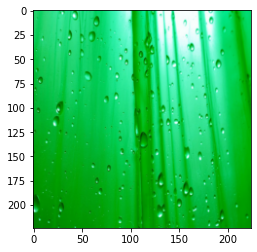

In [174]:
plt.imshow(mushrooms_downsized[182],cmap='Greys')

In [175]:
def isqrt(n):
    """
    This returns the largest integer x for which x * x does not exceed n. 
    If you want to check if the result is exactly the square root, simply 
    perform the multiplication to check if n is a perfect square.
    """
    x = n
    y = (x + 1) // 2
    while y < x:
        x = y
        y = (x + n // x) // 2
    return x

In [176]:
def plot_mushroom_coll(x = 25):
    """
    We can see a collection of random mushrooms with the labels
    x is the number of mushrooms you want to see and it will give 
    the appropriate number of n * n array.
    """
    for i in range(x):
        ran = random.randint(0,len(y)-1)
        plt.subplot(int(np.sqrt(x)), int(np.sqrt(x)), i+1)
        plt.imshow(X[ran], cmap='Greys')
        plt.axis('off')
        plt.text(0, 0, y[ran]) # displays y-values in each subplot


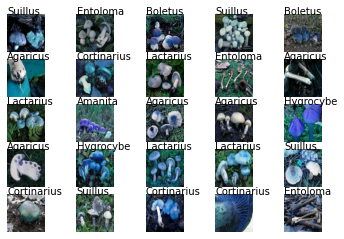

In [138]:
plot_mushroom_coll(x = 25)

- Prepare data to go inside the CNN models

- flatten data

In [195]:
# flatten X into one dimension:
xtrain= X.reshape(X.shape[0],-1) # where 2700 is the 
xtrain.shape

(2700, 150528)

In [199]:
# one-hot-encode labels
ytrain = to_categorical(y)
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

- model RESNET

In [202]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image # Keras own inbuild image class
import os
from tensorflow.keras.models import Model
from tensorflow import keras

In [203]:
model = ResNet50V2()

2022-05-31 23:32:34.841451: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


102883328/102869336 [==============================] - 16s 0us/step
